Defense stocks analysis
The project is set to track the correlation between multiple tickers and predict their movements.
As the stocks are heavily influenced by the geo-political news, decisions, and tweets (X posts), I believe is a curious exercice.
To understand the true implication of a geo-political narative and a potential correlation between the markets a mini portfolio was created as per the tickers below. 
The additional complexity arises from different trading time zone, that will impact the indicator choice.

Choose tickers : 
France : Dassault Aviation société anonyme (0IAX.IL)
France : Safran SA (0IU8.IL)
Germany : Rheinmetall AG (0NI1.IL)
Germany : Accelleron Industries AG (ACLNZ.XC)
Japan : Namura Shipbuilding Co., Ltd. (7014.T)
Japan : MITSUI E&S Co., Ltd. (7003.T)
China : Jianglong Shipbuilding Co., Ltd. (300589.SZ)
China : Guandian Defense Technology Co.,Ltd. (688287.SS)
US : BAE Systems plc (BAESF)
US : Kratos Defense & Security Solutions, Inc. (KTOS)

Source of data : yfinance
Timeframe : 02/01/2023 to 31/12/2025
Prediction period : 01/01/2026 to 31/01/26 





In [83]:
# main imports
#main funcitonalities
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
#ML
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error)


In [84]:
#import of the downloaded ticker data

data = pd.read_csv('defense_portfolio_usd.csv')
portfolio_defense = pd.DataFrame(data)
# as the data contains timestamp in the date and in order to avoid additional problems downstream with the pivoting a clean data will be inserted
portfolio_defense['Date'] = pd.to_datetime(portfolio_defense['Date'],dayfirst=True).dt.date

portfolio_defense.head(5)

,Ticker,Date,Open,High,Low,Close,Volume
0,EPA:AM,2023-01-02,171.77688,174.59112,171.01920,174.59112,22161
1,EPA:AM,2023-01-03,172.75104,174.26640,169.39560,170.91096,48893
2,EPA:AM,2023-01-04,171.34392,171.77688,165.06600,165.17424,53439
3,EPA:AM,2023-01-05,165.06600,167.88024,162.79296,163.22592,67153
4,EPA:AM,2023-01-06,164.20008,167.44728,164.20008,165.71544,43014


In [85]:
#testing the data if dates are aligned and no missing trade dates are present

#pivoting the data so each column is a ticker, that will create an index of dates that exist in the csv

pivot_df = portfolio_defense.pivot(index='Date', columns = 'Ticker', values = 'Close')

#generate a reference calendar of business days

data_range = pd.date_range(start= pivot_df.index.min(),
                           end = pivot_df.index.max(),
                           freq = "B").date
#Inserting NaN for every date that was in the calendar but not in the data
audit_df = pivot_df.reindex(data_range)
#filter for the rows that miss atleast 1 trading day
missing_report = audit_df[audit_df.isnull().any(axis=1)]

print(missing_report.head(20))
print(audit_df.info())

Ticker         EPA:AM     EPA:SAF    ETR:RHM  NASDAQ:KTOS  NYSE:LHX  \
Date                                                                  
2023-01-02  174.59112  128.307696  213.17868          NaN       NaN   
2023-01-16  164.63304  137.140080  233.69016          NaN       NaN   
2023-01-23  179.35368  142.205712  240.72576        10.72    194.25   
2023-01-24  171.77688  142.097472  241.48344        10.78    194.72   
2023-01-25  169.17912  141.036720  239.10216        10.89    197.68   
2023-01-26  170.36976  142.876800  246.24600        10.99    196.54   
2023-01-27  168.63792  143.093280  247.00368        11.25    212.10   
2023-02-20  176.86416  145.885872  269.51760          NaN       NaN   
2023-04-05  198.94512  145.799280  279.47568        12.90    197.40   
2023-04-07        NaN         NaN        NaN          NaN       NaN   
2023-04-10        NaN         NaN        NaN        12.88    199.22   
2023-05-01        NaN         NaN        NaN        13.09    194.71   
2023-0

In [86]:
#Noting that several discrepencies persist due to public holidays and the global aspect of the portfolio
#Example Lunar New Year 1 week on chinese stock is absent, at the time of opening post New year in european stocks US stocks are dormant
#and Easter period is mostly closed to the exception on Schenzen market that might stay open.

#To normalise the data the forward fill will be used (the last known price will be forward pasted)
#Close to the stock market rules were the last available price (before opening) is used as indicator for the trading
audit_df = pivot_df.reindex(data_range)
portfolio_cleaned = audit_df.ffill().bfill().dropna()
ptf = portfolio_cleaned.reset_index()
ptf.rename(columns={'index':'Date'}, inplace= True)
ptf.columns.name = None
print(ptf.head())



ptf.info()


         Date     EPA:AM     EPA:SAF    ETR:RHM  NASDAQ:KTOS  NYSE:LHX  \
0  2023-01-02  174.59112  128.307696  213.17868        10.03    206.93   
1  2023-01-03  170.91096  127.723200  217.02120        10.03    206.93   
2  2023-01-04  165.17424  128.805600  215.39760        10.21    206.93   
3  2023-01-05  163.22592  128.589120  218.75304        10.28    206.13   
4  2023-01-06  165.71544  132.485760  226.65456        10.55    206.18   

   SHE:300589   SWX:ACLN  
0     1.65675  21.538958  
1     1.65675  21.538958  
2     1.71174  22.340822  
3     1.73430  22.630384  
4     1.74135  23.499070  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         783 non-null    object 
 1   EPA:AM       783 non-null    float64
 2   EPA:SAF      783 non-null    float64
 3   ETR:RHM      783 non-null    float64
 4   NASDAQ:KTOS  783 non-null    flo

In [87]:
# pivoting the data back to "long" format for the ease of the application 

portfolio_final = portfolio_cleaned.reset_index()
portfolio_final.rename(columns={'index':'Date'}, inplace= True)

portfolio_final.columns.name = None

print(portfolio_final.head())

         Date     EPA:AM     EPA:SAF    ETR:RHM  NASDAQ:KTOS  NYSE:LHX  \
0  2023-01-02  174.59112  128.307696  213.17868        10.03    206.93   
1  2023-01-03  170.91096  127.723200  217.02120        10.03    206.93   
2  2023-01-04  165.17424  128.805600  215.39760        10.21    206.93   
3  2023-01-05  163.22592  128.589120  218.75304        10.28    206.13   
4  2023-01-06  165.71544  132.485760  226.65456        10.55    206.18   

   SHE:300589   SWX:ACLN  
0     1.65675  21.538958  
1     1.65675  21.538958  
2     1.71174  22.340822  
3     1.73430  22.630384  
4     1.74135  23.499070  


In [88]:
#after the filling and the dropping of the NA the data is operational.
# calculating the returns expressed in % as the pricing of the stocks are very different and the impact between the stocks will be minimal

returns = portfolio_final.set_index('Date').pct_change().dropna()
print(returns.head())


              EPA:AM   EPA:SAF   ETR:RHM  NASDAQ:KTOS  NYSE:LHX  SHE:300589  \
Date                                                                          
2023-01-03 -0.021079 -0.004555  0.018025     0.000000  0.000000    0.000000   
2023-01-04 -0.033566  0.008475 -0.007481     0.017946  0.000000    0.033191   
2023-01-05 -0.011796 -0.001681  0.015578     0.006856 -0.003866    0.013180   
2023-01-06  0.015252  0.030303  0.036121     0.026265  0.000243    0.004065   
2023-01-09 -0.007838 -0.002124  0.017192    -0.019905 -0.024784   -0.007287   

            SWX:ACLN  
Date                  
2023-01-03  0.000000  
2023-01-04  0.037229  
2023-01-05  0.012961  
2023-01-06  0.038386  
2023-01-09 -0.000474  


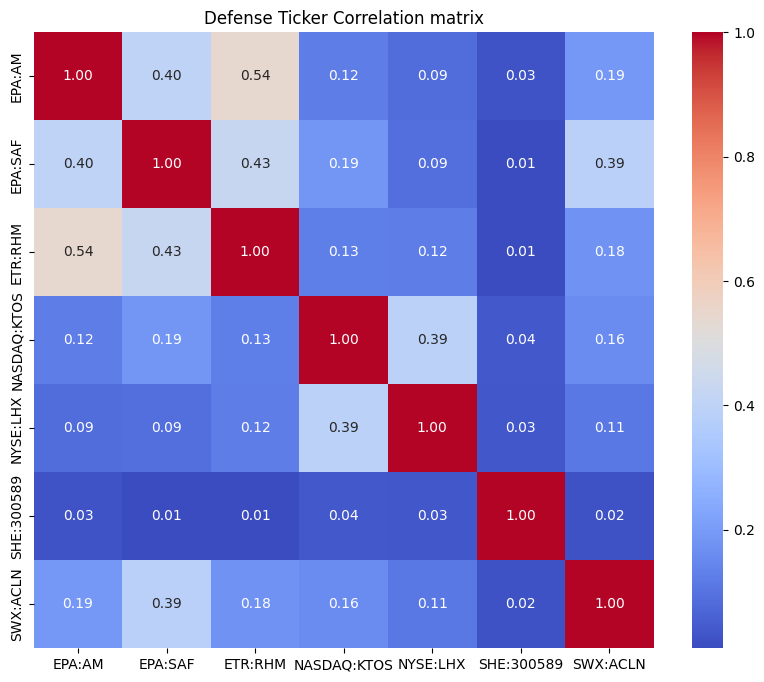

In [89]:
#correlation assessment

corr_matrix = returns.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Defense Ticker Correlation matrix')
plt.show()

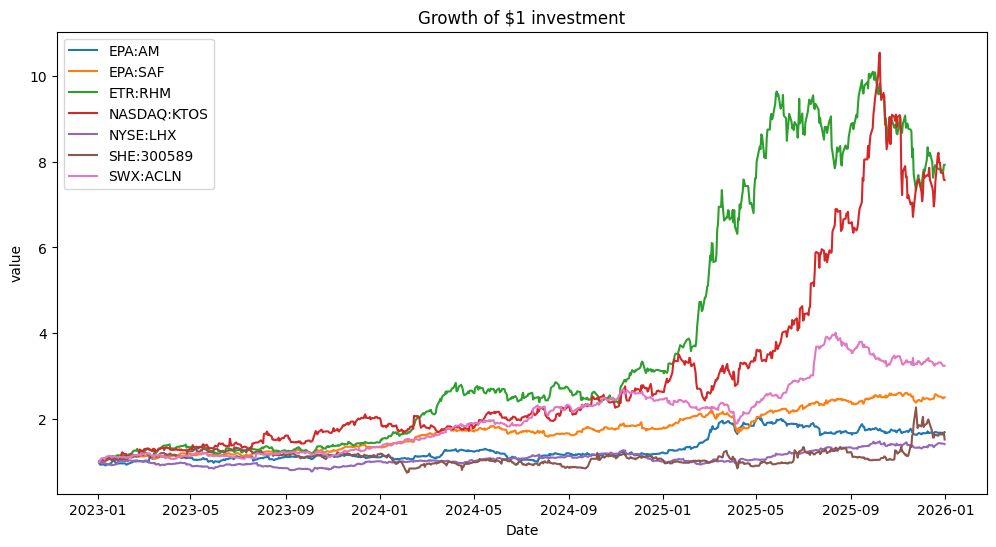

In [90]:
#calculation of cumulative returns

cumulative_returns = (1+returns).cumprod()

cumulative_returns.plot(figsize=(12,6))
plt.title('Growth of $1 investment')
plt.ylabel('value')
plt.show()

In [91]:
#measurement of the volatility and sharpe ratio
# as the data was annualised for the business days, the amount was brought to 252 days for the volatily calculations
volatility = returns.std()/np.sqrt(252)

#sharpe ratio

sharpe_ratio = (returns.mean()*252)/volatility

metrics = pd.DataFrame({'Annual Volatility': volatility, 'Sharpe Ratio':sharpe_ratio})  
print(metrics.sort_values(by='Sharpe Ratio', ascending=False))

             Annual Volatility  Sharpe Ratio
ETR:RHM               0.001503    491.571047
SWX:ACLN              0.000969    422.196689
NASDAQ:KTOS           0.001834    413.453644
EPA:SAF               0.000872    367.880070
EPA:AM                0.001123    187.094487
NYSE:LHX              0.000836    161.206533
SHE:300589            0.002105    130.109781


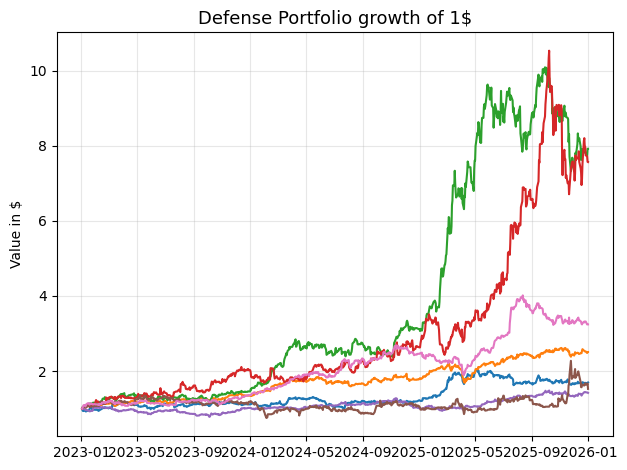

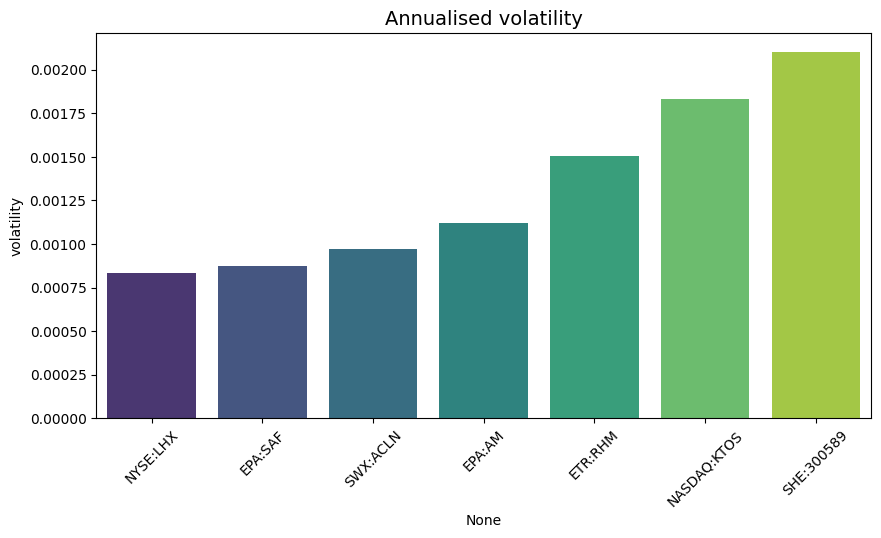

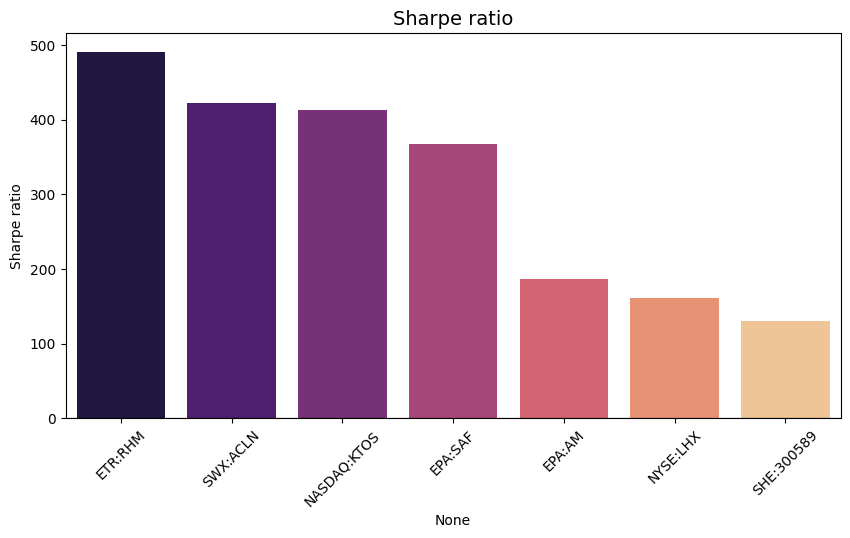

In [92]:
#plotting the resutls
#cumulative revenue
for ticker in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)
plt.title('Defense Portfolio growth of 1$', fontsize= 13)
plt.ylabel('Value in $')
plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()

#valatility comparison
plt.figure(figsize=(10,5))
vol_sorted = volatility.sort_values()
sns.barplot(x=vol_sorted.index, y=vol_sorted.values, palette = 'viridis')
plt.title('Annualised volatility', fontsize= 14)
plt.ylabel('volatility')
plt.xticks(rotation = 45)
plt.show()

#Sharpe ratio

plt.figure(figsize=(10,5))
sharpe_sorted = sharpe_ratio.sort_values(ascending=False)
sns.barplot(x=sharpe_sorted.index, y=sharpe_sorted.values, palette = 'magma')
plt.title('Sharpe ratio', fontsize=14)
plt.ylabel('Sharpe ratio')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.show()

In [93]:
#Technical Analysis code 
def calculate_oscillators(df, ticker, window=14):
    data= df[['Date', ticker]].copy()
    data.columns = ['Date', 'Close']

    #RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta>0,0)).rolling(window = window).mean()
    loss = (-delta.where(delta>0,0)).rolling(window = window).mean()
    rs = gain/loss
    data['RSI'] = 100 - (100/(1+ rs))

    # Stochastic oscillator
    low_min = data['Close'].rolling(window=window).min()
    high_max = data['Close'].rolling(window=window).max()
    data['%K'] = 100*(data['Close'] - low_min)/(high_max-low_min)
    data['%D'] = data['%K'].rolling(window=3).mean()

    # Williams %r

    data['Williams_%R'] = -100 *(high_max-data['Close'])/(high_max-low_min)

    return data

ticker_to_analyse = portfolio_final.columns[1]
tech_analysis = calculate_oscillators(portfolio_final, ticker_to_analyse)

print(f"Latest indicators for {ticker_to_analyse}")
print(tech_analysis.tail(1))

Latest indicators for EPA:AM
           Date     Close  RSI         %K         %D  Williams_%R
782  2025-12-31  296.2516 -inf  83.870968  58.064516   -16.129032


In [94]:
#Creating the dashboard

def plot_technical_dashboard(portfolio_final, ticker):
    df_tech = calculate_oscillators(portfolio_final, ticker)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (14, 10), sharex = True,
                                        gridspec_kw={'height_ratios':[3, 1, 1]})
    #price chart
    ax1.plot(df_tech['Date'], df_tech['Close'], color='black', label='Price')
    ax1.set_title(f"{ticker} - Technical Analysis Dashboard", fontsize = 16)
    ax1.set_ylabel('Price USD')
    ax1.grid(True, alpha=0.3)

    #RSI
    ax2.plot(df_tech['Date'], df_tech['RSI'], color='purple', label='RSI (14)')
    ax2.axhline(70, color='red', linestyle='--')#overbought line
    ax2.axhline(30, color='green', linestyle = '--')#oversold line
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0,100)

    #Williams %R chart
    ax3.plot(df_tech['Date'], df_tech['Williams_%R'], color='blue', label='Williams %R')
    ax3.axhline(-20, color='red', linestyle = '--')#overbought
    ax3.axhline(-80, color = 'green', linestyle = '--')#oversold
    ax3.set_ylabel('Williams %R')
    ax3.set_ylim(-100,0)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

ticker_list = [col for col in portfolio_final.columns if col != 'Date']
@interact(ticker=widgets.Dropdown(options=ticker_list, description='Select Stock:'))
def interactive_dashboard(ticker):
    # Calculate the values for a quick text summary
    df_tech = calculate_oscillators(portfolio_final, ticker)
    latest_rsi = df_tech['RSI'].iloc[-1]
    
    # Simple logic for the "Callout" text
    status = "Neutral"
    if latest_rsi > 70: status = "OVERBOUGHT (Watch for drop)"
    elif latest_rsi < 30: status = "OVERSOLD (Watch for bounce)"
    
    print(f"--- {ticker} Current Status: {status} (RSI: {latest_rsi:.2f}) ---")
    
    plt.close('all')
    plot_technical_dashboard(portfolio_final, ticker)

interactive(children=(Dropdown(description='Select Stock:', options=('EPA:AM', 'EPA:SAF', 'ETR:RHM', 'NASDAQ:K…

In [95]:
#feature engineering SMA20, SMA 50, Volatility 20, 
ticker_list = [col for col in portfolio_final.columns if col != 'Date']
all_ticker_features = {}

def engineer_features_final(df, ticker, horizon=5):
    data = calculate_oscillators(df, ticker)

    data['SMA_20']= data['Close'].rolling(window=20).mean()
    data['SMA_50']= data['Close'].rolling(window=50).mean()

    data['Dist_SMA20'] = (data['Close']/ data['SMA_20'])-1
    data['Dist_SMA50'] = (data['Close']/ data['SMA_50'])-1

    data['Vol_20']= data['Close'].pct_change().rolling(window=20).std()

    data['Target_Next_Ret'] = data['Close'].pct_change(periods=horizon).shift(-horizon)

    return data.dropna()

for ticker in ticker_list:
    all_ticker_features[ticker] = engineer_features_final(portfolio_final, ticker)

example_ticker = ticker_list[0]
print(f"feature set ready for: {ticker_list[0]}")
print(all_ticker_features[example_ticker].columns.tolist())



feature set ready for: EPA:AM
['Date', 'Close', 'RSI', '%K', '%D', 'Williams_%R', 'SMA_20', 'SMA_50', 'Dist_SMA20', 'Dist_SMA50', 'Vol_20', 'Target_Next_Ret']


-- Audit report forEPA:AM--
        Close     SMA_20  Dist_SMA20  Target_Next_Ret
773  295.1696  291.58818    0.012282        -0.003666
774  297.3336  292.07508    0.018004        -0.010917
775  294.5204  292.50788    0.006880        -0.006613
776  293.2220  292.90822    0.001071         0.005166
777  294.0876  293.12462    0.003285         0.007358


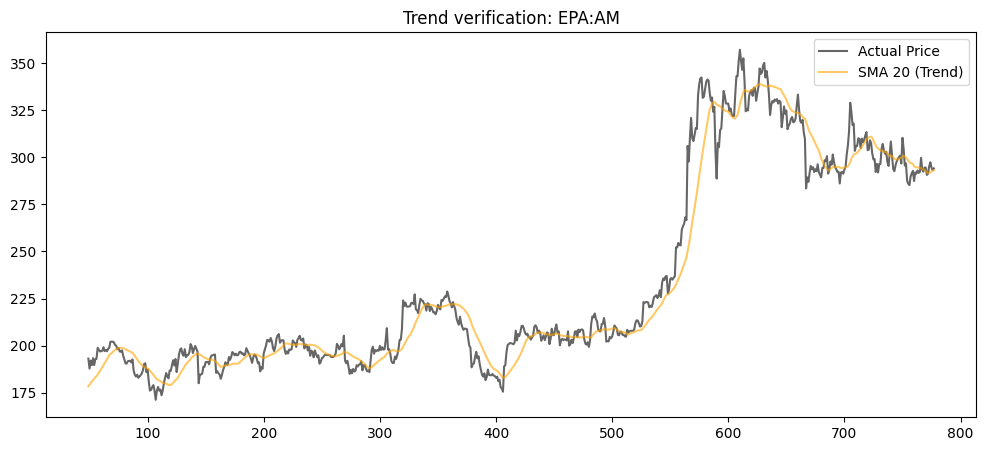

In [96]:
#sanity check verification test

test_ticker = ticker_list[0]
test_df = all_ticker_features[test_ticker]

print(f"-- Audit report for{test_ticker}--")
columns_to_show =['Close', 'SMA_20', 'Dist_SMA20', 'Target_Next_Ret']
print(test_df[columns_to_show].tail())


plt.figure(figsize=(12,5))
plt.plot(test_df.index, test_df['Close'], label='Actual Price', color='black', alpha = 0.6)
plt.plot(test_df.index, test_df['SMA_20'], label='SMA 20 (Trend)', color='orange', alpha = 0.6)
plt.title(f"Trend verification: {test_ticker}")
plt.legend()
plt.show()

In [97]:
# preparation for the training of the model 

#combining all ticker data 
#set_index() with append=true keeps the date but adds the ticker to the index

full_dataset=pd.concat(all_ticker_features.values(), keys=all_ticker_features.keys())
full_dataset.index.names=['Ticker', 'Date']

print(f"total rows for training : {len(full_dataset)}")
print(full_dataset.head())

total rows for training : 5103
                   Date      Close  RSI         %K         %D  Williams_%R  \
Ticker Date                                                                  
EPA:AM 49    2023-03-10  193.10016 -inf  95.897436  65.299145    -4.102564   
       50    2023-03-13  187.79640 -inf  70.769231  88.888889   -29.230769   
       51    2023-03-14  192.01776 -inf  90.769231  85.811966    -9.230769   
       52    2023-03-15  189.63648 -inf  79.487179  80.341880   -20.512821   
       53    2023-03-16  193.31664 -inf  96.923077  89.059829    -3.076923   

                 SMA_20      SMA_50  Dist_SMA20  Dist_SMA50    Vol_20  \
Ticker Date                                                             
EPA:AM 49    178.401168  172.279114    0.082393    0.120856  0.029355   
       50    179.218380  172.543219    0.047864    0.088402  0.030186   
       51    180.176304  172.965355    0.065721    0.110152  0.030434   
       52    180.928572  173.454600    0.048129    0.0932

Note that some stocks might have a free fall leading to a negative infinity in the RSI indicator. 
To alianate this effect that will freeze the model, inf will be assigned a neutral state of 50

In [98]:
feature_cols = [
    'RSI', '%K', 'Williams_%R', 'Dist_SMA20', 'Dist_SMA50', 'Vol_20']
target_col = 'Target_Next_Ret'

X = full_dataset[feature_cols].copy()
y = full_dataset[target_col]
#replacing the Infity to nan to make them identifiable
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(50, inplace=True)


assert not np.isinf(X).values.any() #identifying if still infinities exist 
assert not X.isnull().values.any() # identifuing if nan still exist





In [99]:
#standard scaler

scaler = StandardScaler()

X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)

print('Original volatility ', X['Vol_20'].mean())
print('Scaled volatility mean', X_scaled['Vol_20'].mean())

Original volatility  0.019548377024695224
Scaled volatility mean 6.683529554474781e-17


In [100]:
#splitting the data 

dates = full_dataset.index.get_level_values('Date').unique().sort_values()
split_idx = int(len(dates)*0.8)
split_date = dates[split_idx]

X_train_raw = X[X.index.get_level_values('Date') <=split_date]
X_test_raw = X[X.index.get_level_values('Date')> split_date]

y_train = y[y.index.get_level_values('Date')<=split_date]
y_test = y[y.index.get_level_values('Date') > split_date]

X_train = pd.DataFrame(scaler.fit_transform(X_train_raw),
                       columns=X_train_raw.columns,
                       index=  X_train_raw.index)

X_test = pd.DataFrame(scaler.fit_transform(X_test_raw),
                       columns=X_test_raw.columns,
                       index=  X_test_raw.index)

print(f"split date : {split_date}")

print(f"X_train rows: {X_train.shape[0]}")
print(f"y_train rows: {y_train.shape[0]}")

assert X_train.shape[0] == y_train.shape[0]

if X_train.isnull().values.any() or y_train.isnull().values.any():
    print("warning nan detected")
else:
    print('ready for workout, all sets are clean and finite') 

split date : 632
X_train rows: 4088
y_train rows: 4088
ready for workout, all sets are clean and finite


Model Benchmarking 
Models involved : 
Ridge regression
Random forest
XGBoost
SVR
Lasso

LSTM was considered during the initial plan, however the volume of data is slightly insufficient to properly apply the model and risk an overfitting. 
KNN is not most adapted to the current situation except if we would like to test the outliers and link them to the media events of the bullish/bearish moment.

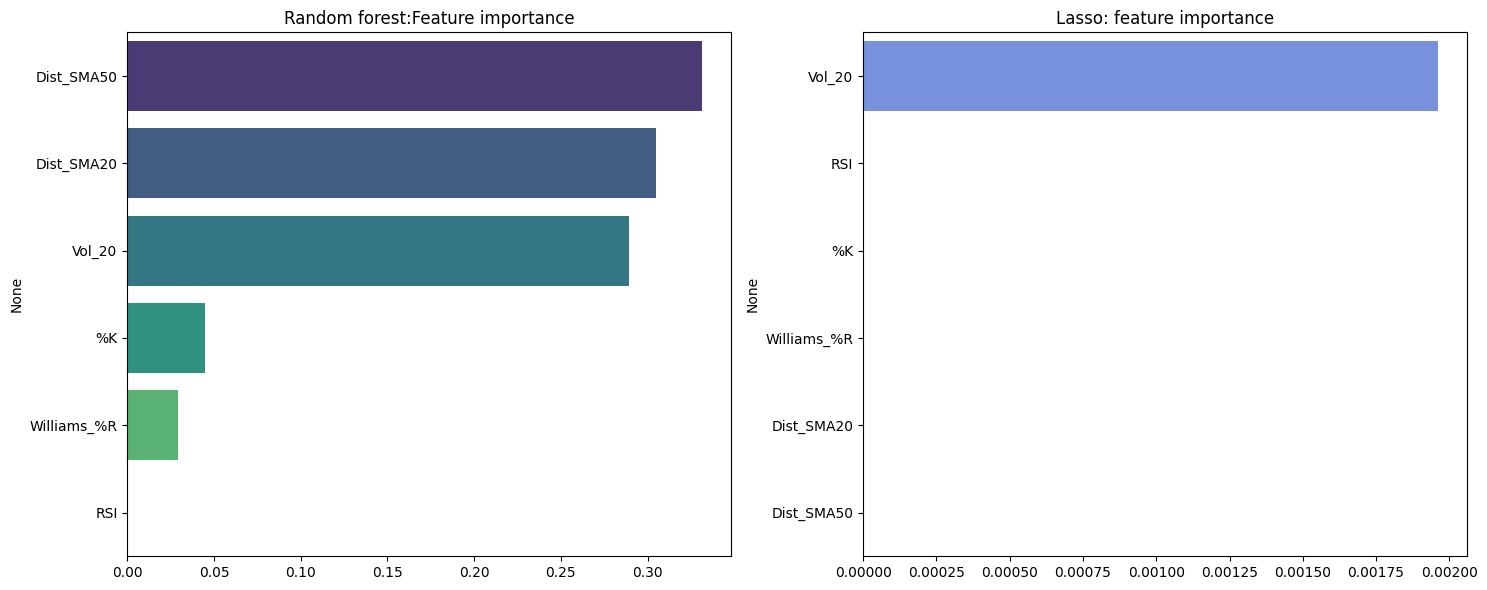

In [101]:
#feature audit
#Ensure that the model will use the technical indicators rather than just memorizing the pricing level by extracting future importance and coefficients. 

rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train, y_train)

#extract importances 

rf_importances = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
lasso_coeffs = pd.Series(lasso_model.coef_, index=feature_cols).sort_values(ascending=False)

#visualisation 

fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.barplot(x=rf_importances.values, y=rf_importances.index, ax=ax[0], palette='viridis')
ax[0].set_title('Random forest:Feature importance')

sns.barplot(x=lasso_coeffs.values, y=lasso_coeffs.index, ax=ax[1], palette='coolwarm')
ax[1].set_title('Lasso: feature importance')

plt.tight_layout()
plt.show()

For the Random forest it is noted that the top 3 contenders are the market sentiment indicators that are used for the decisioning
For the Lasso which is a linear model we note that there's no straight line relantionship except volatility

The RSI and SMA disctances dont' have a simple if X goes up by 1 Y will follow by 2, their relantionship appears to be conditional. 
Random forest can observe this relantionship Lasso cannot

In [102]:
#0 initialisation

models = {
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest" : RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42),
    "Gradien Boosting" : GradientBoostingRegressor(n_estimators=200, learning_rate=0.03, max_depth=4, random_state=42),
    "Lasso" : Lasso(alpha=0.001),
    "SVR" : SVR(kernel='rbf', C=1.0, epsilon=0.01)
}

#1 Benchmarking
results = []
preds_dict = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds=model.predict(X_test)
    preds_dict[name]=preds

    #calculate directional accuracy (did it guess the right direction)
    #We use np.sign to see if both pred and actual are positive or both negative

    dir_acc = np.mean(np.sign(preds)==np.sign(y_test))

    results.append({
        'Model': name,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE" : np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds),
        "Dir_Accuracy": dir_acc
    })

performance_df = pd.DataFrame(results).sort_values(by="MAE")
print('--Performance leaderboard--')
print(performance_df)    

leaderboard = pd.DataFrame(results).sort_values(by="MAE").set_index("Model")
print(leaderboard)


--Performance leaderboard--
              Model       MAE      RMSE        R2  Dir_Accuracy
3             Lasso  0.039664  0.066595  0.001487      0.536946
0  Ridge Regression  0.039730  0.066604  0.001224      0.536946
1     Random Forest  0.039750  0.066888 -0.007289      0.543842
2  Gradien Boosting  0.040142  0.067198 -0.016676      0.542857
4               SVR  0.041367  0.070584 -0.121710      0.533990
                       MAE      RMSE        R2  Dir_Accuracy
Model                                                       
Lasso             0.039664  0.066595  0.001487      0.536946
Ridge Regression  0.039730  0.066604  0.001224      0.536946
Random Forest     0.039750  0.066888 -0.007289      0.543842
Gradien Boosting  0.040142  0.067198 -0.016676      0.542857
SVR               0.041367  0.070584 -0.121710      0.533990


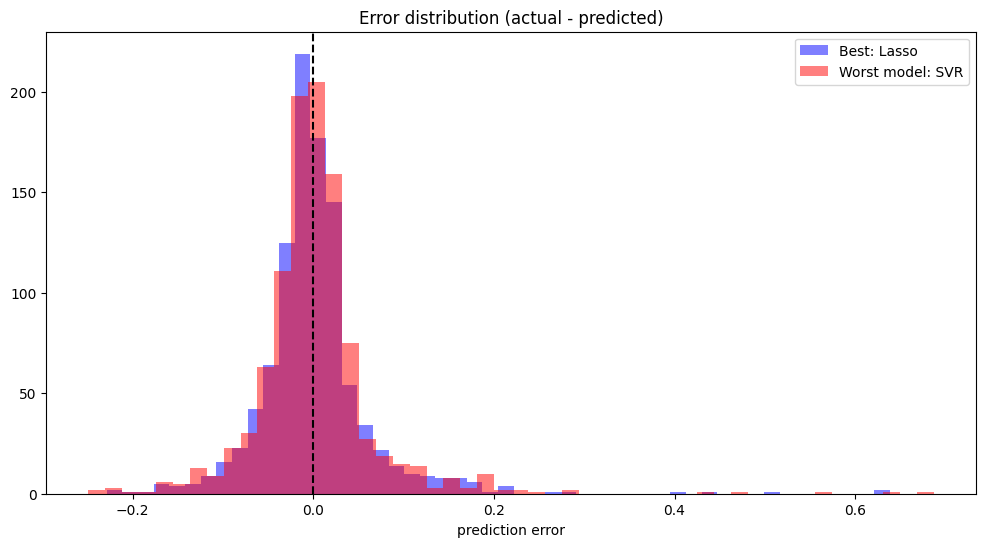

In [103]:
#visualisation of the models

best_model_name = leaderboard.index[0]
worst_model_name = leaderboard.index[-1]

plt.figure(figsize=(12,6))
plt.hist(y_test - preds_dict[best_model_name], bins=50, alpha=0.5, label=f"Best: {best_model_name}", color="blue")
plt.hist(y_test - preds_dict[worst_model_name], bins=50, alpha=0.5, label=f'Worst model: {worst_model_name}', color="red")
plt.axvline(0, color="Black", linestyle="--")
plt.title("Error distribution (actual - predicted)")
plt.xlabel("prediction error")
plt.legend()
plt.show()

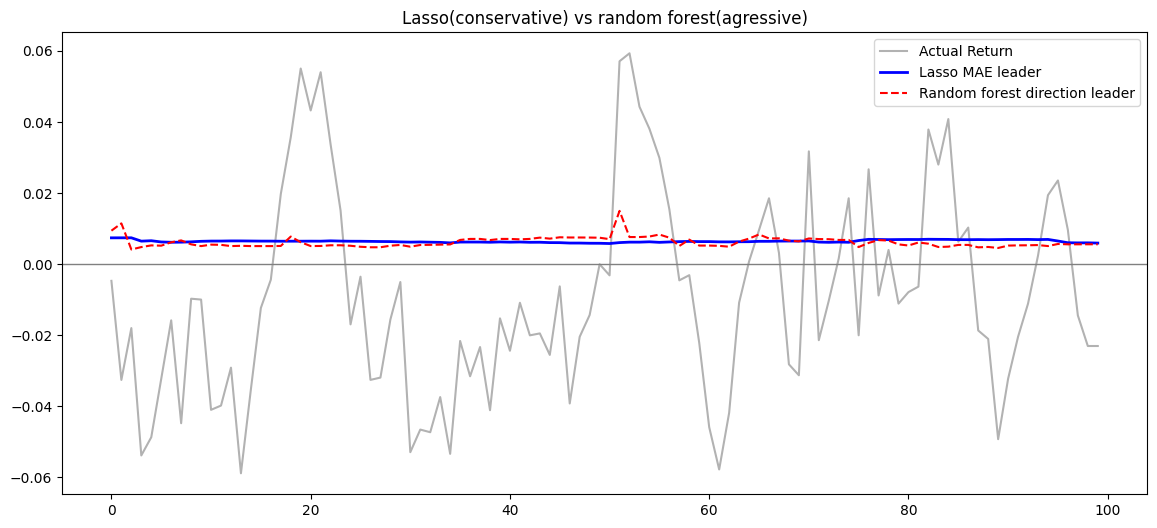

In [104]:
#creation of a comparison between top 1 and top2 

plt.figure(figsize=(14,6))

plt.plot(y_test.values[-100:], label='Actual Return', color='black', alpha=0.3)
plt.plot(preds_dict['Lasso'][-100:], label = 'Lasso MAE leader', color = 'blue', lw=2)
plt.plot(preds_dict['Random Forest'][-100:], label = 'Random forest direction leader', color= 'red', linestyle='--')

plt.axhline(0,color='gray', lw=1)
plt.title("Lasso(conservative) vs random forest(agressive)")
plt.legend()
plt.show()

Based on the previous results the lasso and dandom forest direction present the best results, in order to perfect the approach an ensemble techique using 50% of LAsso and 50% of random forest will be implemented

In [105]:
ensemble_preds = (preds_dict['Lasso']+ preds_dict['Random Forest'])/2

ensemble_dir_acc = np.mean(np.sign(ensemble_preds)==np.sign(y_test))
ensemble_mae = mean_absolute_error(y_test, ensemble_preds)

print(f"ensemble MAE: {ensemble_mae:.5f}")
print(f"enxemble directional accuracy: {ensemble_dir_acc:.2%}")

ensemble MAE: 0.03966
enxemble directional accuracy: 53.69%


Visualisation of the ensemble curve to assess the movement prediction

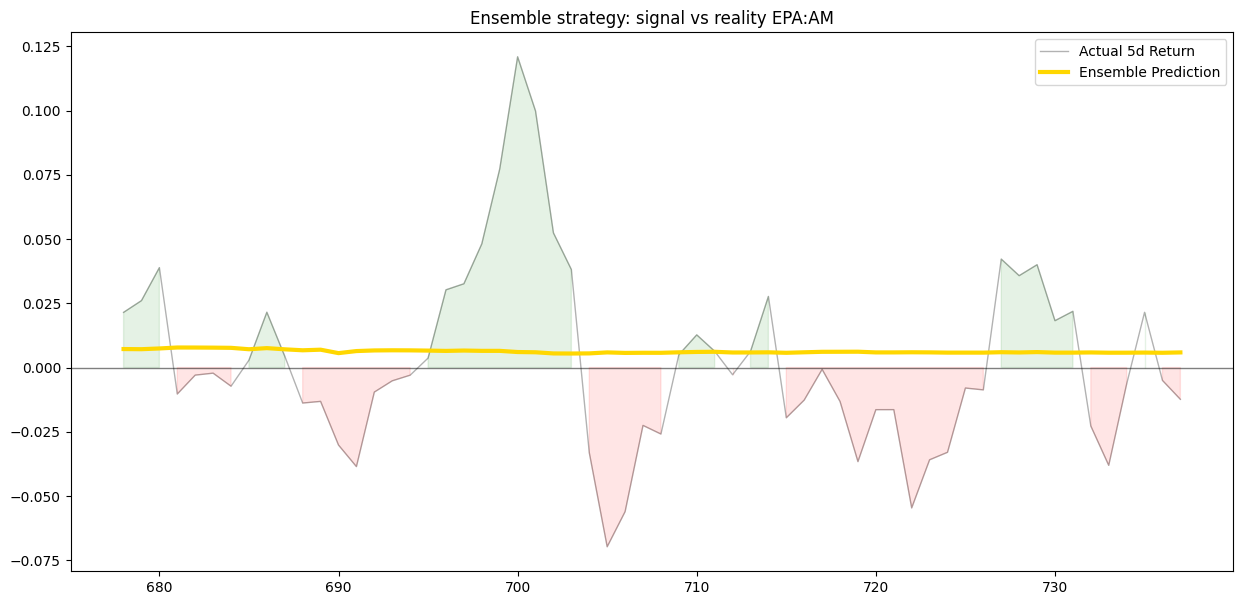

In [106]:
vis_df= pd.DataFrame({
    'Actual': y_test.values,
    'Ensemble': ensemble_preds,
    'Lasso': preds_dict['Lasso'],
    'RF': preds_dict['Random Forest']
}, index = y_test.index)

target_ticker = vis_df.index.get_level_values('Ticker').unique()[0]
single_ticker_df = vis_df.xs(target_ticker, level='Ticker')

#zomming in to 60 days window for clarity
sample_window = single_ticker_df.iloc[-100:-40]

plt.figure(figsize=(15,7))
plt.plot(sample_window['Actual'], label='Actual 5d Return', color='black', alpha=0.3, linewidth = 1)
plt.plot(sample_window['Ensemble'], label= 'Ensemble Prediction', color='gold',linewidth=3)
plt.fill_between(sample_window.index, sample_window['Actual'], 0, where=(sample_window['Actual']>0), color='green', alpha = 0.1)
plt.fill_between(sample_window.index, sample_window['Actual'], 0, where=(sample_window['Actual']<0), color='red', alpha=0.1)

plt.axhline(0, color='black', lw=1, alpha=0.5)
plt.title(f"Ensemble strategy: signal vs reality {target_ticker}")
plt.legend()
plt.show()

Noting a positive bias in the ensemble technique as the oscillations are small and not interpreting properly the swings that the stock went through. 


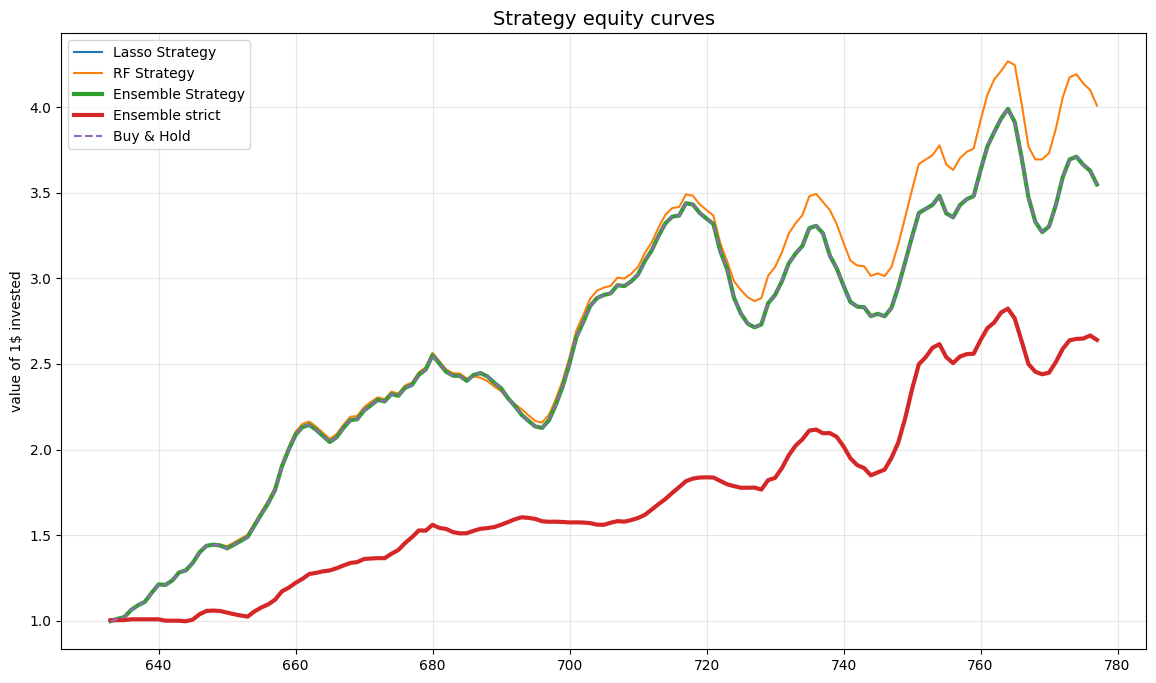

In [107]:
#baccktesting the ensemble model 

#combining the actual returns with the predictions

backtest_results = pd.DataFrame({
    'Actual_Ret': y_test.values, 
    'Lasso_Pred': preds_dict['Lasso'],
    'RF_Pred': preds_dict['Random Forest'], 
    'Ensemble_Pred': ensemble_preds
}, index=y_test.index)

#definition of a standard threshold 0.2% 

threshold = 0.002
strict_val = np.percentile(ensemble_preds, 70)

#calculating the strategy returns (signal * actual)
# If pred > threshold, we are long (1), else Cash(0)

strategies = ['Lasso_Pred', 'RF_Pred', 'Ensemble_Pred']

for strat in strategies: 
    signal_col = f'Signal_{strat}'
    ret_col = f'Ret_{strat}'

    backtest_results[signal_col] = (backtest_results[strat]> threshold).astype(int)
    backtest_results[ret_col] = backtest_results[signal_col]* backtest_results['Actual_Ret']

backtest_results['Signal_Ensemble_Strict'] = (backtest_results['Ensemble_Pred'] > strict_val).astype(int)
backtest_results['Ret_Ensemble_Strict'] = backtest_results['Signal_Ensemble_Strict'] * backtest_results['Actual_Ret']

ret_columns = [f"Ret_{s}" for s in strategies] + ['Ret_Ensemble_Strict']
daily_returns = backtest_results.groupby(level='Date')[ret_columns + ['Actual_Ret']].mean()

equity_curves = pd.DataFrame(index= daily_returns.index)
equity_curves['Lasso Strategy'] = (1+daily_returns['Ret_Lasso_Pred']).cumprod()
equity_curves['RF Strategy']=(1+daily_returns['Ret_RF_Pred']).cumprod()
equity_curves['Ensemble Strategy']=(1+daily_returns['Ret_Ensemble_Pred']).cumprod()
equity_curves['Buy & Hold']=(1+daily_returns['Actual_Ret']).cumprod()
equity_curves = (1 + daily_returns).cumprod()
equity_curves.columns = ['Lasso Strategy', 'RF Strategy', 'Ensemble Strategy', 'Ensemble strict', 'Buy & Hold']

# visualisation 

plt.figure(figsize=(14,8))
for column in equity_curves.columns:
    linewidth = 3 if 'Ensemble' in column else 1.5
    linestyle = '--' if 'Buy & Hold' in column else '-'
    plt.plot(equity_curves[column], label=column, linewidth=linewidth, linestyle=linestyle)

plt.title ("Strategy equity curves", fontsize = 14)
plt.ylabel('value of 1$ invested')
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()    



In [108]:
#audit metrics

def calculate_metrics (returns): 
    #annualised sharpe ratio under 252 trading days assumption
    sharpe = (returns.mean() / returns.std())*np.sqrt(252)
    cum_ret = (1+returns).cumprod()
    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max)/ running_max
    max_dd = drawdown.min()

    return pd.Series({'Sharpe Ratio': sharpe, 'Max Drawdown': max_dd, 'Total Return': cum_ret.iloc[-1]-1})
audit_table = pd.DataFrame ({
    'Lasso': calculate_metrics(daily_returns['Ret_Lasso_Pred']),
    'Random Forest' : calculate_metrics(daily_returns['Ret_RF_Pred']),
    'Ensemble': calculate_metrics(daily_returns['Ret_Ensemble_Pred']),
    'Ensemble Strict': calculate_metrics(daily_returns['Ret_Ensemble_Strict']),
    'Buy & Hold' : calculate_metrics(daily_returns['Actual_Ret'])
}).T 

print(audit_table)


                 Sharpe Ratio  Max Drawdown  Total Return
Lasso                5.591551     -0.210909      2.548412
Random Forest        6.427565     -0.178698      3.009365
Ensemble             5.591551     -0.210909      2.548412
Ensemble Strict      6.002300     -0.135940      1.640338
Buy & Hold           5.591551     -0.210909      2.548412


Interpretation : 

Lassos flatline, if the model shows a very low max drawdown but lower total return is acting defensively
the RF volatitly has the highest return but a max drawdown as well more onto the agressive side and can pick false signals
the Ensemble hit a wall with the threshold, thus a stricter threshold was created to achieve a better representation. 

based on the metrics above can be noted that random forest is the money maker, and the Ensemble stric will act as the safety net.

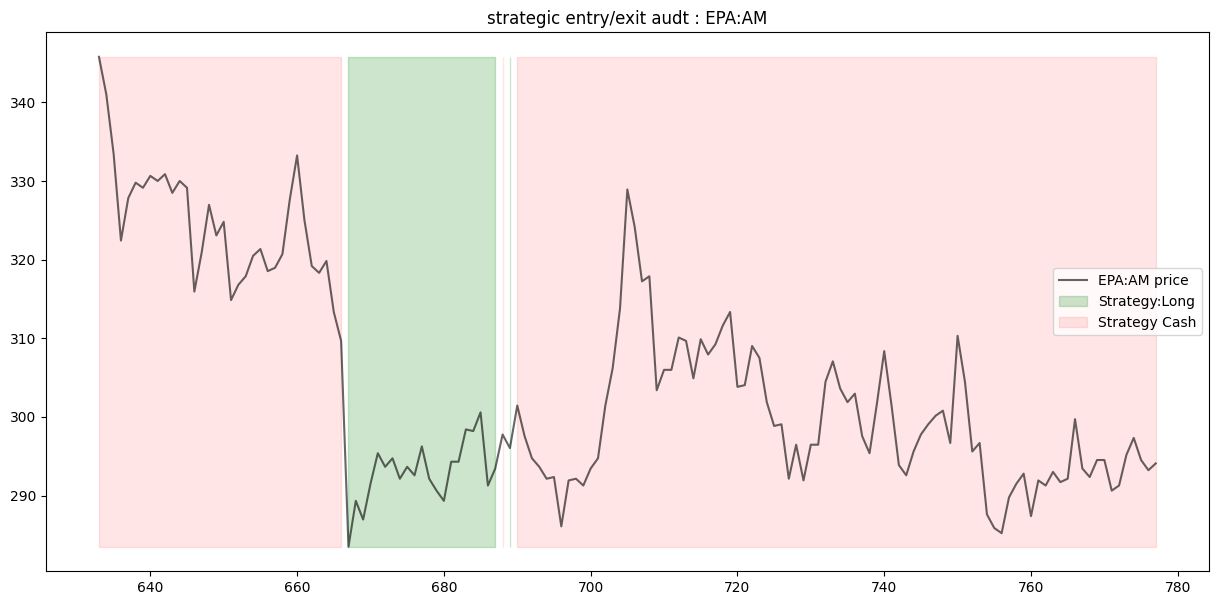

In [109]:
# final visualisation 

test_ticker = X_test.index.get_level_values('Ticker').unique()[0]
ticker_prices = full_dataset.xs(test_ticker, level='Ticker')['Close'].loc[y_test.xs(test_ticker, level='Ticker').index]
ticker_signals = backtest_results.xs(test_ticker, level='Ticker')['Signal_Ensemble_Strict']

plt.figure(figsize=(15,7))
plt.plot(ticker_prices.index, ticker_prices, label=f'{test_ticker} price', color='black', alpha=0.6)
plt.fill_between(ticker_prices.index, ticker_prices.min(), ticker_prices.max(), 
                 where = (ticker_signals == 1), color='green', alpha=0.2, label = 'Strategy:Long')
plt.fill_between(ticker_prices.index, ticker_prices.min(), ticker_prices.max(), where=(ticker_signals == 0), color='red', alpha=0.1, label='Strategy Cash')

plt.title(f"strategic entry/exit audt : {test_ticker}")
plt.legend()
plt.show()

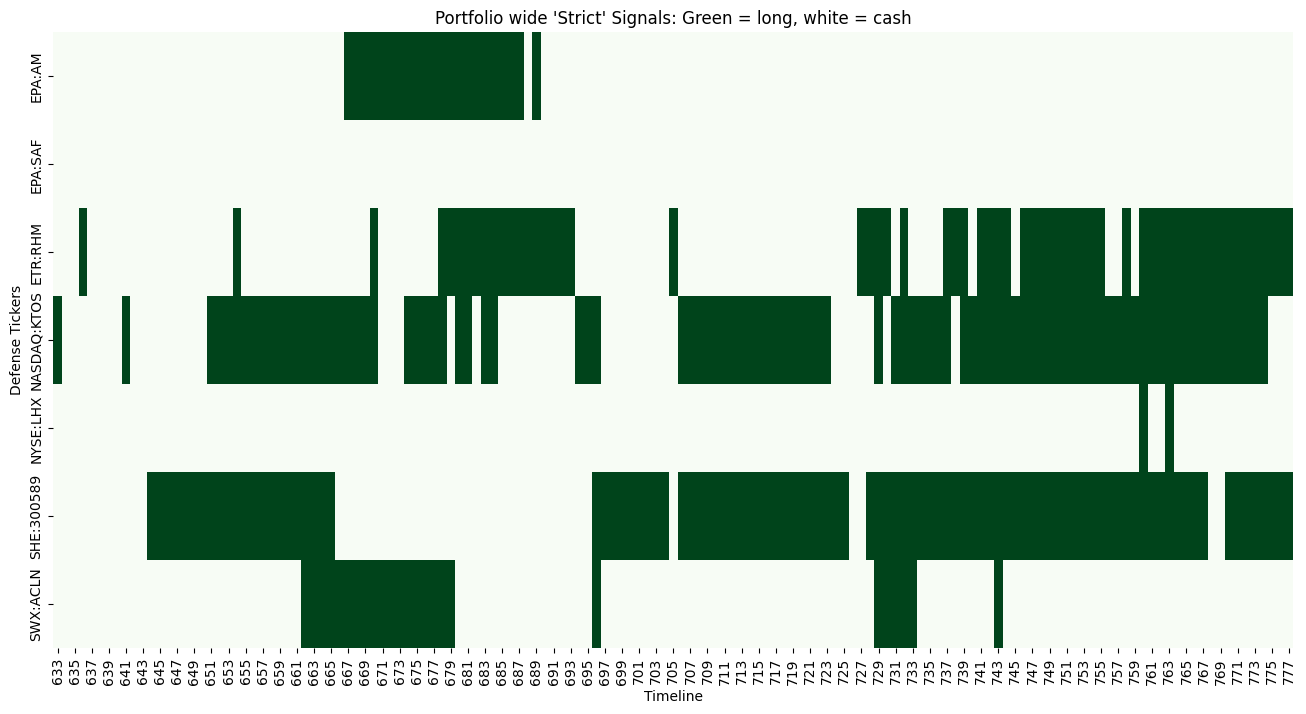

In [110]:
#visualisation of the integrity of the porfolio via a heatmap 

signal_matrix = backtest_results['Signal_Ensemble_Strict'].unstack(level='Ticker')

plt.figure(figsize=(16,8))
sns.heatmap(signal_matrix.T, cmap='Greens', cbar=False, yticklabels=True)
plt.title("Portfolio wide 'Strict' Signals: Green = long, white = cash")
plt.xlabel("Timeline")
plt.ylabel("Defense Tickers")
plt.show()

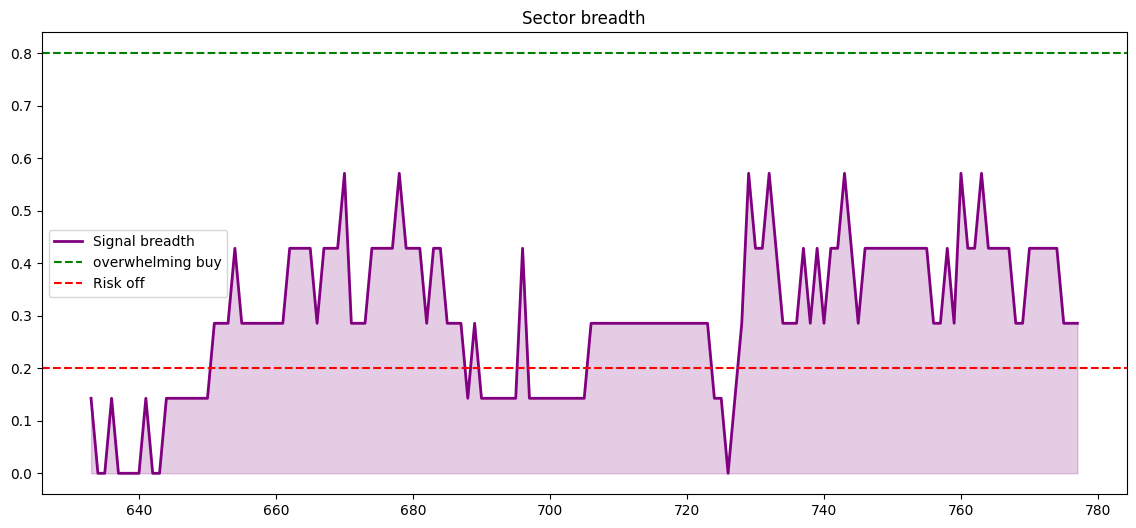

In [111]:
#signal Breadth buy all vs none
#creation of the Conviction score from 0% to 100% when is the best moment to buy simultaneously
# Breadth > 80% high conviction sector (buy all)
# Breadth 30-70% Selective opportunities
#Breadth <20% Sector exhautstion (none or cash out)

breadth = signal_matrix.mean(axis=1)

breadth_analysis = pd.DataFrame({
    'Breadth': breadth, 
    'Market_Return': daily_returns['Actual_Ret']
})

plt.figure(figsize=(14,6))
plt.plot(breadth.index, breadth, label='Signal breadth', color = 'purple', lw=2)
plt.axhline(0.8, color='green', linestyle='--', label='overwhelming buy')
plt.axhline(0.2, color='red', linestyle='--', label= 'Risk off')
plt.fill_between(breadth.index, 0, breadth, alpha=0.2, color='purple')
plt.title('Sector breadth')
plt.legend()
plt.show()

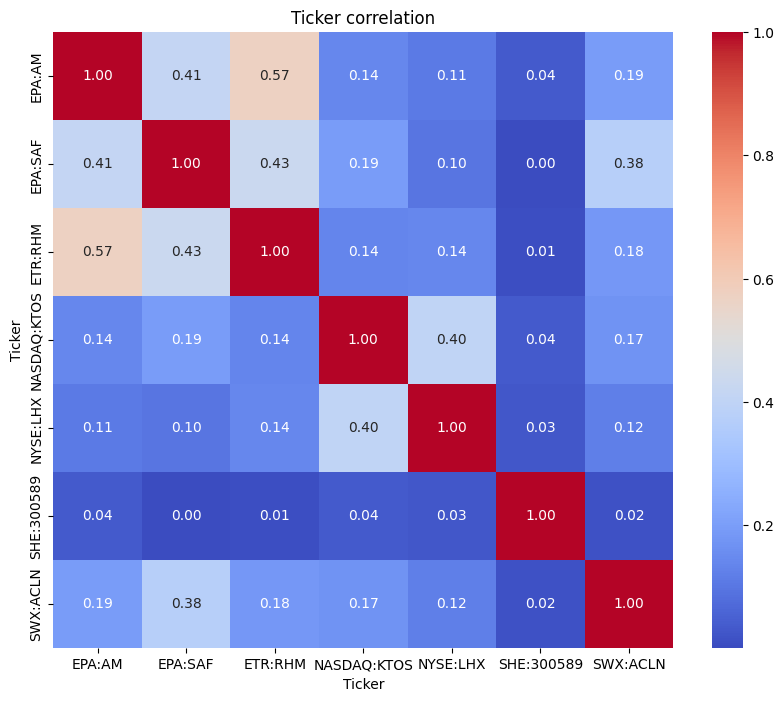

In [112]:
#meta-analytics correlation audit 

correlation_matrix = full_dataset['Close'].unstack(level='Ticker').pct_change().corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Ticker correlation')
plt.show() 

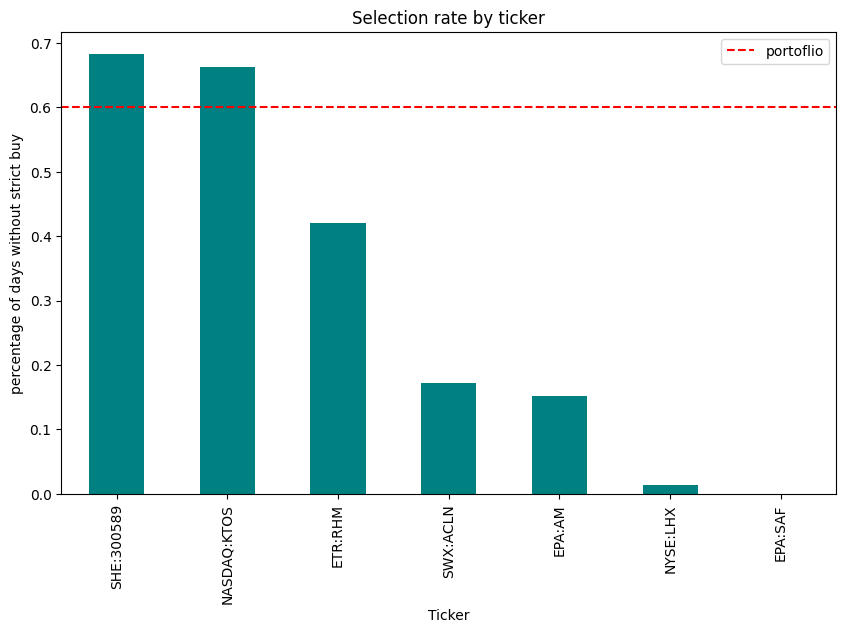

In [113]:
# as the portfolio was giving out mostly selective breadth it is necessary to visualise which stocks should be picked out

ticker_selection_rate = signal_matrix.mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ticker_selection_rate.plot(kind='bar', color='teal')
plt.title('Selection rate by ticker')
plt.ylabel('percentage of days without strict buy')
plt.axhline(0.6, color='red', linestyle='--', label='portoflio')
plt.legend()
plt.show()

In [114]:
#creation of the python script for futrure usage : 

def generate_tactical_report(full_df, feature_cols):

    X = full_df[feature_cols].copy()
    y = full_df['Target_Next_Ret'].copy()

    nan_counts = X.isna().sum()
    if nan_counts.max() > 0:
        print("Missing values per feature:")
        print(nan_counts[nan_counts > 0])

    X=X.replace([np.inf, -np.inf], np.nan)

    temp_df = pd.concat([X,y], axis=1)

    cols_to_drop = temp_df.columns[temp_df.isna().all()]
    if len(cols_to_drop) > 0:
        print(f"Warning: Dropping entirely empty columns: {cols_to_drop.tolist()}")
        temp_df = temp_df.drop(columns=cols_to_drop)
    
    # Drop rows that are still messy
    temp_df = temp_df.dropna()
    
    if len(temp_df) == 0:
        raise ValueError("CRITICAL: No data left after dropping NaNs. Check your indicator calculations!")

    X = temp_df[[c for c in feature_cols if c in temp_df.columns]]
    y = temp_df['Target_Next_Ret']
    

    dates = X.index.get_level_values('Date').unique().sort_values()
    train_cutoff = dates[int(len(dates)*0.8)]

    X_train = X[X.index.get_level_values('Date')<=train_cutoff]
    y_train = y[y.index.get_level_values('Date')<=train_cutoff]

    scaler = StandardScaler()
    X_train_scaled= scaler.fit_transform(X_train)

    model_lasso = Lasso(alpha=0.001).fit(X_train_scaled, y_train)
    model_rf = RandomForestRegressor(n_estimators=200, max_depth=5).fit(X_train_scaled, y_train)

    latest_date = dates[-1]
    X_latest = X[X.index.get_level_values('Date')==latest_date]
    X_latest_scaled = scaler.transform(X_latest)

    lasso_pred = model_lasso.predict(X_latest_scaled)
    rf_pred = model_rf.predict(X_latest_scaled)
    ensemble_pred = (lasso_pred + rf_pred)/2

    historical_preds = (model_lasso.predict(X_train_scaled)+model_rf.predict(X_train_scaled))/2
    strict_threshold = np.percentile(historical_preds, 70)

    report = pd.DataFrame({
        'Ensemble_score': ensemble_pred, 
        'Signal' : (ensemble_pred > strict_threshold).astype(int)

    }, index=X_latest.index.get_level_values('Ticker'))

    report['Action'] = report['Signal'].map({1: 'Buy/hold', 0:'Cash'})

    breadth = report['Signal'].mean()

    return report, breadth, strict_threshold

report, breadth, threshold = generate_tactical_report(full_dataset, feature_cols)


# Convert the last index value to a Timestamp first, then call .date()
last_date_val = full_dataset.index.get_level_values('Date')[-1]
formatted_date = pd.to_datetime(last_date_val).date()

print(f"-- Tactical Analysis: {formatted_date} --")
print(f"Sector Breadth: {breadth:.1%} | Confidence Threshold: {threshold:.4f}")
print("-" * 50)
print(report[['Ensemble_score', 'Action']])


-- Tactical Analysis: 1970-01-01 --
Sector Breadth: 42.9% | Confidence Threshold: 0.0068
--------------------------------------------------
             Ensemble_score    Action
Ticker                               
EPA:AM             0.005736      Cash
EPA:SAF            0.005404      Cash
ETR:RHM            0.009562  Buy/hold
NASDAQ:KTOS        0.011877  Buy/hold
NYSE:LHX           0.005688      Cash
SHE:300589         0.019140  Buy/hold
SWX:ACLN           0.005742      Cash


In [115]:
def final_tactical_suite(df_input, feature_cols, total_capital=10000):
    # 1Cleaning
    X = df_input[feature_cols].copy().replace([np.inf, -np.inf], np.nan)
    y = df_input['Target_Next_Ret'].copy()
    
    # DROP columns that are empty 
    null_pct = X.isnull().mean()
    bad_cols = null_pct[null_pct > 0.3].index.tolist()
    if bad_cols:
        print(f"Dropping high-NaN features: {bad_cols}")
        X = X.drop(columns=bad_cols)
        feature_cols = [f for f in feature_cols if f not in bad_cols]

    # FILL gaps using forward fill
    X = X.ffill().bfill() 

    # Combine and drop only the remaining NAs 
    temp_df = pd.concat([X, y], axis=1).dropna()
    
    if temp_df.empty:
        # check: if it's still empty, it's likely the Target_Next_Ret is missing
        print("Final attempt: Checking if Target_Next_Ret is the issue...")
        # If we have no target, we can't TRAIN, but we can still PREDICT
        # Let's adjust the logic to keep the latest row for inference
        X_latest_row = X.groupby(level='Ticker').tail(1) 
        # (This would require a more complex architectural change)
        raise ValueError("Dataset still empty. Try reducing the 'Lookback' of your indicators.")

    X, y = temp_df[feature_cols], temp_df['Target_Next_Ret']

    # 2. Training
    dates = X.index.get_level_values('Date').unique().sort_values()
    train_cutoff = dates[int(len(dates)*0.8)]
    
    X_train = X[X.index.get_level_values('Date') <= train_cutoff]
    y_train = y[y.index.get_level_values('Date') <= train_cutoff]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    model_lasso = Lasso(alpha=0.001).fit(X_train_scaled, y_train)
    model_rf = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42).fit(X_train_scaled, y_train)
    
    # 3. Inference
    latest_Date = dates[-1] 
    X_latest = X[X.index.get_level_values('Date') == latest_Date]
    X_latest_scaled = scaler.transform(X_latest)
    
    ensemble_pred = (model_lasso.predict(X_latest_scaled) + model_rf.predict(X_latest_scaled)) / 2
    hist_preds = (model_lasso.predict(X_train_scaled) + model_rf.predict(X_train_scaled)) / 2
    strict_thresh = np.percentile(hist_preds, 70)

    # 4. Risk & Stop Loss - FIXED UNSTACK LOGIC
    tickers = X_latest.index.get_level_values('Ticker')
    
    # Instead of .xs, we pivot the full dataframe Close prices
    # This is more robust against index flattening
    recent_prices = df_input['Close'].unstack(level='Ticker').ffill() 
    
    vol_20d = recent_prices.pct_change().tail(20).std()
    curr_prices = recent_prices.iloc[-1]
    
    stop_loss_pct = vol_20d * 2
    stop_prices = curr_prices * (1 - stop_loss_pct)

    # 5. Report Assembly
    # Fixed 'vold_20d' typo to 'vol_20d'
    report = pd.DataFrame({
        'Price': curr_prices[tickers],
        'Pred_Return': ensemble_pred,
        'Action': ['BUY/HOLD' if p > strict_thresh else 'CASH' for p in ensemble_pred],
        'volatility': vol_20d[tickers]
    }, index=tickers)

    # 6. Allocation Logic
    # Fixed 'Aciton' and 'BUY/Hold' casing typos
    buy_mask = report['Action'] == 'BUY/HOLD'
    
    if buy_mask.any():
        buys = report[buy_mask].copy()
        inv_vol = 1 / buys['volatility']
        buys['Weight_%'] = (inv_vol / inv_vol.sum()) * 100
        buys['Allocation_$'] = (buys['Weight_%'] / 100) * total_capital
        buys['Stop_Loss_Price'] = stop_prices[buys.index]
        
        final_output = buys[['Price', 'Pred_Return', 'Weight_%', 'Allocation_$', 'Stop_Loss_Price']]
    else:
        final_output = "No high-confidence signals. Stay in CASH."

    breadth = buy_mask.mean()
    return final_output, breadth

# --- EXECUTION ---
portfolio_action, sector_breadth = final_tactical_suite(full_dataset, feature_cols, total_capital=50000)

print(f"--- Tactical Suite | Sector Breadth: {sector_breadth:.0%} ---")
print(portfolio_action)

Dropping high-NaN features: ['RSI']
--- Tactical Suite | Sector Breadth: 43% ---
                 Price  Pred_Return   Weight_%  Allocation_$  Stop_Loss_Price
Ticker                                                                       
ETR:RHM      1667.3620     0.008155  48.173354  24086.677176      1594.936687
NASDAQ:KTOS    79.9700     0.012445  29.704897  14852.448583        74.336654
SHE:300589      2.7482     0.015698  22.121748  11060.874241         2.488246
